In [1]:
!pip install torch_geometric
#!pip install torch-geometric torch-scatter torch-sparse torch-cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:0000:01


In [2]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.9 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=80c756813adc44b327538ce10718b172e97b3893ced063b0421f3c885036c4df
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=85218cee1fd04db533ba98e2ae94c61137e9fa725b69e40ef997e84c9a16a9c8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

## `Imports`

In [25]:
import os
import cv2
import torch
import random
from torch import nn, optim
import segmentation_models_pytorch as smp
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import torchvision.models as models
import networkx as nx
from scipy.spatial import distance
from scipy.spatial import cKDTree
from skimage import io

from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, classification_report, precision_recall_curve

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

The SatelliteDataset class is designed to preprocess satellite images and their corresponding masks. The masks are converted into binary representations to distinguish agricultural land (yellow) from non-agricultural land (cyan). The class prepares data for training, validation, and testing.

`Key Attributes`
* image_dir: Path to the directory containing satellite images.
* mask_dir: Path to the directory containing binary masks for images.
* transform: Optional data augmentation and preprocessing transformations.
* images: List of all image filenames within image_dir.
  
`Key Methods`
1. __len__()
    * Returns the total number of images in the dataset.
2. __getitem__(idx)
    * Loads and preprocesses an image and its corresponding mask.
    * Resizes both the image and mask to (512, 512).
    * Converts masks into binary format:
    * Yellow (255, 255, 0): Agricultural land → Label 0.
    * Cyan (0, 255, 255): Non-agricultural land → Label 1.
3. `Dataset Preparation`
    * The dataset is split into 70% training, 15% validation, and 15% testing.
    * Transformations applied:
        * ToTensor: Converts images to PyTorch tensors.
        * Normalize: Normalizes image pixel values to standard ImageNet values.

In [4]:
class SatelliteDataset(Dataset):
    """
    Attributes:
        image_dir (str): Path to the directory containing satellite images.
        mask_dir (str): Path to the directory containing mask images.
        transform (callable, optional): A function/transform to apply to the images and masks (e.g., data augmentation).
        images (list): A list of image file names from the image directory.

    Methods:
        __len__(): Returns the total number of images in the dataset.
        __getitem__(idx): Loads and processes the image and its corresponding mask at the given index. 
                           The mask is converted to a binary format where cyan (non-agricultural) is labeled as 1 
                           and yellow (agricultural) as 0. Optionally, applies transformations to the image and mask.
    
    Args:
        image_dir (str): Path to the directory containing input satellite images.
        mask_dir (str): Path to the directory containing mask images.
        transform (callable, optional): A function/transform to apply to the images and masks. Defaults to None.
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace("_sat.jpg", "_mask.png"))
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (512, 512))  #Resize image
        
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (512, 512))  #Resize mask
        
        #Convert RGB mask to binary
        mask_binary = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        mask_binary[np.all(mask == [0, 255, 255], axis=-1)] = 1  # Cyan -> 1
        mask_binary[np.all(mask == [255, 255, 0], axis=-1)] = 0  # Yellow -> 0

        if self.transform:
            image = self.transform(image)
            mask_binary = torch.from_numpy(mask_binary).unsqueeze(0).float()

        return image, mask_binary

#Apply transformations to images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Initialize dataset and split
dataset = SatelliteDataset(image_dir="/kaggle/input/practice1/dummy/images/", mask_dir="/kaggle/input/practice1/dummy/masks/", transform=transform)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

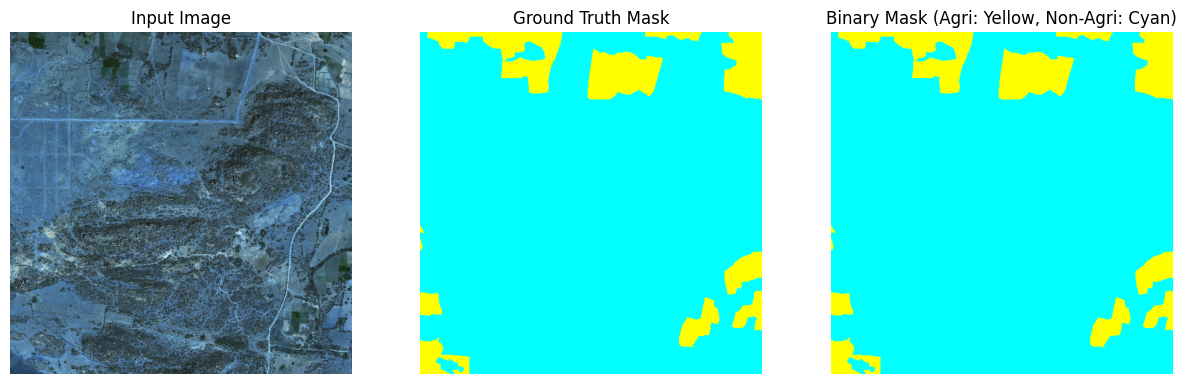

In [5]:
def visualize_random_sample_rgb(dataset):
    """
    Visualizes a random sample from the given dataset by displaying:
    1. The original image.
    2. The corresponding ground truth mask, with agricultural land (1) in yellow and non-agricultural land (0) in cyan.
    3. A binary mask representation where agricultural land is in yellow and non-agricultural land is in cyan.

    This function performs the following steps:
    - Randomly selects an index from the dataset.
    - Retrieves the corresponding image and mask.
    - Converts the image from tensor format (C, H, W) to a numpy array (H, W, C) for visualization.
    - Applies normalization to the image for proper visualization.
    - Converts the mask to an RGB format, where the agricultural land (1) is shown in yellow and the non-agricultural land (0) is shown in cyan.
    - Displays the image, the ground truth mask, and the binary mask side-by-side.

    Args:
        dataset (torch.utils.data.Dataset): The dataset containing image-mask pairs, where each element consists of an image tensor and its corresponding mask tensor.
        
    Returns:
        None: The function displays the images directly using `matplotlib`.
    """
    #Mag random select og index
    idx = random.randint(0, len(dataset) - 1)
    
    #kuhaon and image apil iyang corresponding mask
    image, mask = dataset[idx]
    
    #Convert image from Tensor to NumPy for visualization
    image = image.permute(1, 2, 0).numpy()  #Convert (C, H, W) to (H, W, C)
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
    mask = mask.squeeze(0).numpy()  #Remove the channel dimension from the mask

    #Create og RGB color maps para sa binary mask
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    mask_rgb[mask == 1] = [255, 255, 0]  #Agricultural land(1) in Yellow
    mask_rgb[mask == 0] = [0, 255, 255]  #Non-agricultural land(0) in Cyan

    #Plot the image, ground truth mask, and binary mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    #Display the image
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[0].axis('off')
    
    #Display the ground truth mask
    ax[1].imshow(mask_rgb)
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis('off')
    
    #Display the binary mask
    ax[2].imshow(mask_rgb)
    ax[2].set_title("Binary Mask (Agri: Yellow, Non-Agri: Cyan)")
    ax[2].axis('off')
    
    plt.show()


visualize_random_sample_rgb(dataset)

## Convolutional Neural network Framework

`Model Architecture`
- U-Net with ResNet50 Encoder:
- Encoder pre-trained on ImageNet.
- Outputs binary masks for classification.
  
`Loss Function`
- Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss): Suitable for binary segmentation tasks.
  
`Optimizer`
- Adam Optimizer: Learning rate = 1e-4.

In [6]:
unet_model = smp.Unet(
    encoder_name="resnet50",        #Encoder: ResNet50
    encoder_weights="imagenet",    #Pre-trained on ImageNet
    in_channels=3,                 #RGB images
    classes=1                      #Binary classification
).to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  #For binary classification
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 332MB/s]


## Training Process
    The training loop includes:

- Forward Pass: Predict binary masks from input images.
- Loss Calculation: Compute BCE loss between predicted and ground truth masks.
- Backward Pass: Update weights using gradients.

`Accuracy Metrics:`
- Training and validation accuracy computed using binary thresholds (> 0.5).
- Training progress is logged at regular intervals, including loss and accuracy for both training and validation sets.

In [7]:
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    model.train()
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Training
        model.train()
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device).unsqueeze(1)  # Ensure channel dimension
            masks = masks.squeeze(1)  # Remove extra dimension if present
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate training accuracy
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold
            train_correct += (preds == masks).sum().item()
            train_total += masks.numel()
        
        # Validation
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device).unsqueeze(1)  # Ensure channel dimension
                masks = masks.squeeze(1)  # Remove extra dimension if present
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Calculate validation accuracy
                preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid and threshold
                val_correct += (preds == masks).sum().item()
                val_total += masks.numel()
        
        # Calculate average losses and accuracies
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_acc:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "unet_resnet50_with_features.pth")


train_unet(unet_model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


Epoch 1/100, Train Loss: 0.4811, Train Accuracy: 0.7772, Val Loss: 0.3235, Val Accuracy: 0.8742


100%|██████████| 71/71 [01:34<00:00,  1.33s/it]


Epoch 11/100, Train Loss: 0.1227, Train Accuracy: 0.9582, Val Loss: 0.2402, Val Accuracy: 0.9101


100%|██████████| 71/71 [01:34<00:00,  1.33s/it]


Epoch 21/100, Train Loss: 0.0817, Train Accuracy: 0.9717, Val Loss: 0.2695, Val Accuracy: 0.9127


100%|██████████| 71/71 [01:35<00:00,  1.34s/it]


Epoch 31/100, Train Loss: 0.0660, Train Accuracy: 0.9775, Val Loss: 0.3677, Val Accuracy: 0.9019


100%|██████████| 71/71 [01:34<00:00,  1.34s/it]


Epoch 41/100, Train Loss: 0.1508, Train Accuracy: 0.9436, Val Loss: 0.2470, Val Accuracy: 0.9080


100%|██████████| 71/71 [01:34<00:00,  1.34s/it]


Epoch 51/100, Train Loss: 0.0711, Train Accuracy: 0.9732, Val Loss: 0.3399, Val Accuracy: 0.9054


100%|██████████| 71/71 [01:35<00:00,  1.34s/it]


Epoch 61/100, Train Loss: 0.0365, Train Accuracy: 0.9861, Val Loss: 0.3551, Val Accuracy: 0.9118


100%|██████████| 71/71 [01:35<00:00,  1.34s/it]


Epoch 71/100, Train Loss: 0.0628, Train Accuracy: 0.9766, Val Loss: 0.3468, Val Accuracy: 0.9079


100%|██████████| 71/71 [01:35<00:00,  1.35s/it]


Epoch 81/100, Train Loss: 0.0253, Train Accuracy: 0.9903, Val Loss: 0.4035, Val Accuracy: 0.9096


100%|██████████| 71/71 [01:35<00:00,  1.34s/it]


Epoch 91/100, Train Loss: 0.0601, Train Accuracy: 0.9797, Val Loss: 0.4022, Val Accuracy: 0.9073


100%|██████████| 71/71 [01:35<00:00,  1.34s/it]


## visualize predictions

- Compares the input image, ground truth overlay, and predicted overlay for a given sample.
  
`Overlay colors:`
- Green: Correctly identified agricultural land.

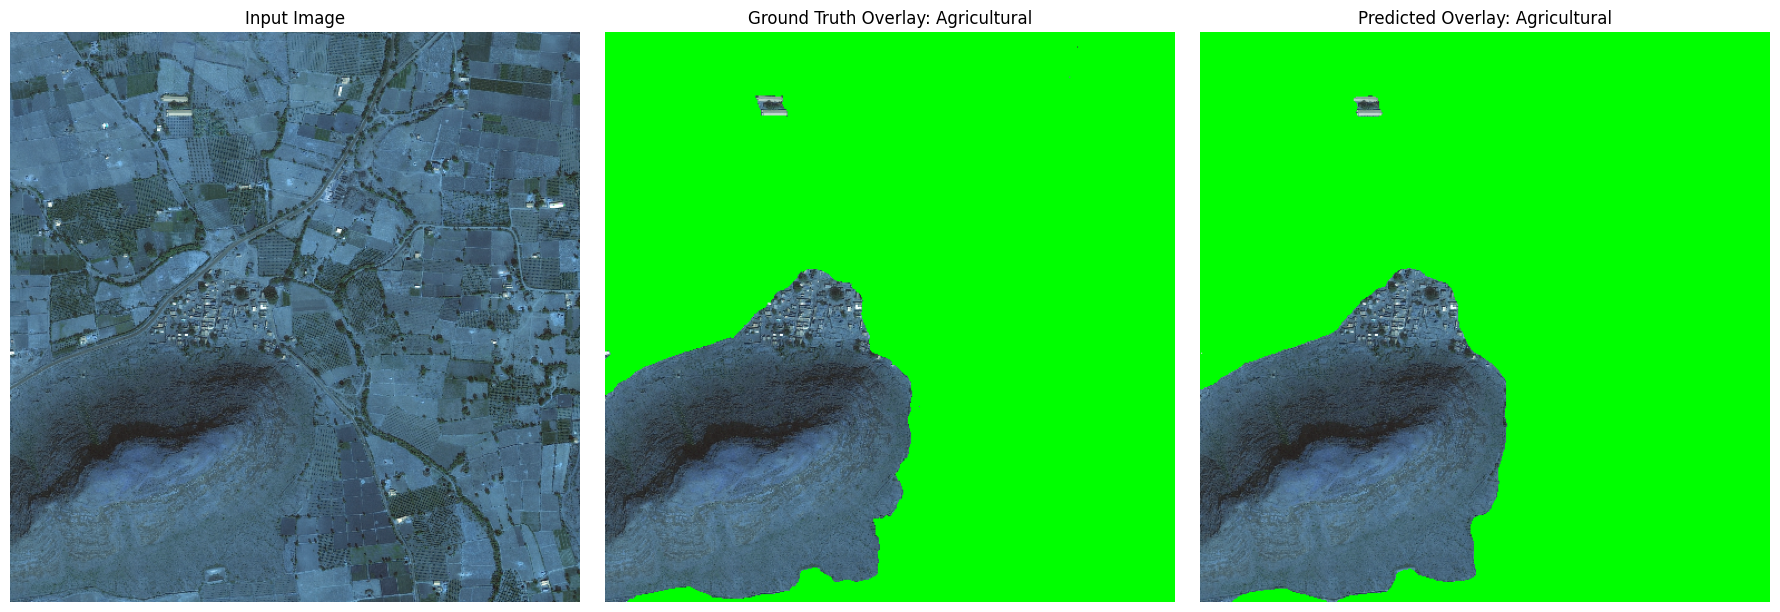

In [8]:
def visualize_predictions(model, dataset, idx=None):
    model.eval()

    #Select a random index if none is provided
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    image, mask = dataset[idx]
    image_np = image.permute(1, 2, 0).numpy()  #Convert to HWC format for visualization
    image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  #Denormalize
    image_np = np.clip(image_np, 0, 1)  #Ensure pixel values are in [0, 1]
    
    mask = mask.squeeze().numpy()  #Convert the mask to numpy array

    image = image.to(device).unsqueeze(0)  #Add batch dimension
    with torch.no_grad():
        pred = torch.sigmoid(model(image)).squeeze().cpu().numpy()
        pred_binary = (pred > 0.5).astype(np.uint8)

    #Overlay masks on the original image
    ground_truth_overlay = image_np.copy()
    ground_truth_overlay[mask == 1] = [0, 128, 0]  #Green for agricultural land (ground truth)

    predicted_overlay = image_np.copy()
    predicted_overlay[pred_binary == 1] = [0, 1, 0]  #Green for agricultural land (prediction)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image_np)
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    ax[1].imshow(ground_truth_overlay)
    ax[1].set_title("Ground Truth Overlay: Agricultural")
    ax[1].axis("off")
    
    ax[2].imshow(predicted_overlay)
    ax[2].set_title("Predicted Overlay: Agricultural")
    ax[2].axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(unet_model, dataset)

## Evaluation
The model is evaluated using:

- Accuracy: Proportion of correctly classified pixels.
- Precision, Recall, F1-Score: Metrics to measure classification quality.
- ROC-AUC: Evaluates the trade-off between true positive rate and false positive rate.
  
`The evaluation also includes:`

ROC Curve Visualization: Highlights the model's performance over different thresholds.

Classification Report:
                   precision    recall  f1-score   support

Non-Agricultural       0.90      0.92      0.91  15270426
    Agricultural       0.92      0.90      0.91  16448998

        accuracy                           0.91  31719424
       macro avg       0.91      0.91      0.91  31719424
    weighted avg       0.91      0.91      0.91  31719424



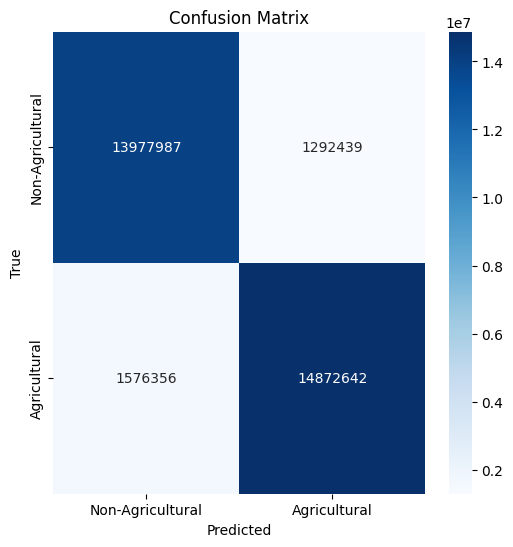

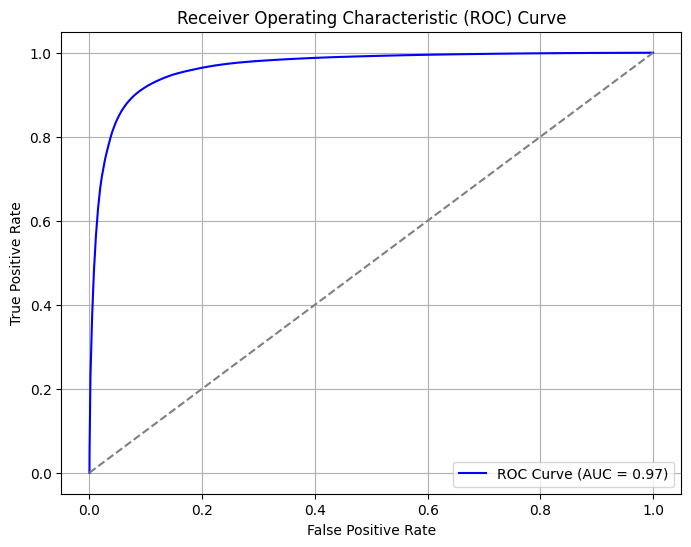

Dice Score: 0.9120
IoU: 0.8383


In [12]:
def evaluate_model_with_visualization(model, test_loader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.view(-1).numpy()
            
            # Get model predictions
            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
            preds_binary = (probs > threshold).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds_binary)
            all_labels.extend(masks)
    
    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=["Non-Agricultural", "Agricultural"])
    print("Classification Report:\n", report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Agricultural", "Agricultural"],
                yticklabels=["Non-Agricultural", "Agricultural"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Dice Score and IoU
    all_preds_tensor = np.array(all_preds)
    all_labels_tensor = np.array(all_labels)
    intersection = np.logical_and(all_preds_tensor, all_labels_tensor).sum()
    union = np.logical_or(all_preds_tensor, all_labels_tensor).sum()
    dice_score = (2 * intersection) / (all_preds_tensor.sum() + all_labels_tensor.sum())
    iou = intersection / union if union != 0 else 0

    print(f"Dice Score: {dice_score:.4f}")
    print(f"IoU: {iou:.4f}")

# Run evaluation
evaluate_model_with_visualization(unet_model, test_loader, threshold=0.5)

## Feature Extraction
Features are extracted using the encoder of the U-Net model:

- Adaptive Average Pooling: Reduces feature maps to a fixed size.
- Flattening: Converts pooled features into a 1D vector.
- Output: Feature matrix for graph construction.

In [13]:
def extract_features(model, data_loader, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            encoder_output = model.encoder(images)
            pooled_features = torch.nn.functional.adaptive_avg_pool2d(encoder_output[-1], (1, 1)) #Apply a 2D adaptive average pooling over an input signal composed of several input planes.
            pooled_features = pooled_features.flatten(start_dim=1)
            features.append(pooled_features.cpu().numpy())
            labels.append(masks.cpu().numpy())
    return np.vstack(features), np.concatenate(labels)

extracted_features, extracted_labels = extract_features(unet_model, train_loader, device)

In [14]:
display(extracted_features.shape)
display(extracted_labels.shape)

(562, 2048)

(562, 1, 512, 512)

## Graph Construction
Graphs are constructed to represent spatial relationships:

- Nodes: Represent parcels of land.
  
`Edges: Formed based on:`
- Spatial Proximity: Using distance thresholds.
- Feature Similarity: Using cosine similarity.

In [15]:
def construct_graph(features, labels, distance_threshold=50, similarity_threshold=0.8):
    """
    Constructs a graph from features and labels and computes centroids.
    
    Parameters:
        features (np.ndarray): Feature matrix of shape (N, F), where N is the number of nodes.
        labels (np.ndarray): Labels for each parcel of shape (N, 1, H, W).
        distance_threshold (int): Distance threshold for spatial edge creation.
        similarity_threshold (float): Similarity threshold for feature-based edge creation.
        
    Returns:
        G (nx.Graph): Constructed graph.
        centroids (np.ndarray): Centroids of the parcels in the resized space.
    """
    G = nx.Graph()
    binary_labels = (labels.mean(axis=(2, 3)) > 0.5).astype(int).squeeze()
    
    #Add nodes with features and binary labels
    for i, (feature, label) in enumerate(zip(features, binary_labels)):
        G.add_node(i, feature=feature, label=label)

    #Compute centroids
    labels_2d = labels.squeeze(1)  #Shape: (N, H, W)
    centroids = []
    for mask in labels_2d:
        if mask.sum() > 0:  #Compute centroid for non-empty mask
            centroid = np.argwhere(mask > 0).mean(axis=0)
        else:
            centroid = np.zeros(2)  #Default value for empty mask
        centroids.append(centroid)
    centroids = np.array(centroids)

    #Create spatial edges
    dist_matrix = np.linalg.norm(centroids[:, None] - centroids[None, :], axis=-1)
    spatial_edges = np.argwhere((dist_matrix < distance_threshold) & (dist_matrix > 0))
    G.add_edges_from((i, j, {"type": "spatial"}) for i, j in spatial_edges)

    #Create feature-based edges
    feature_similarities = cosine_similarity(features)
    feature_edges = np.argwhere((feature_similarities > similarity_threshold) & (np.eye(features.shape[0]) == 0))
    G.add_edges_from((i, j, {"type": "feature"}) for i, j in feature_edges)
    
    return G, centroids

In [16]:
graph, centroids = construct_graph(
    features=extracted_features,
    labels=extracted_labels,
    distance_threshold=50,  #adjust kung needed
    similarity_threshold=0.8  #adjust kung needed
)

In [17]:
display(f"Number of nodes: {graph.number_of_nodes()}")
display(f"Number of edges: {graph.number_of_edges()}")

'Number of nodes: 562'

'Number of edges: 93769'

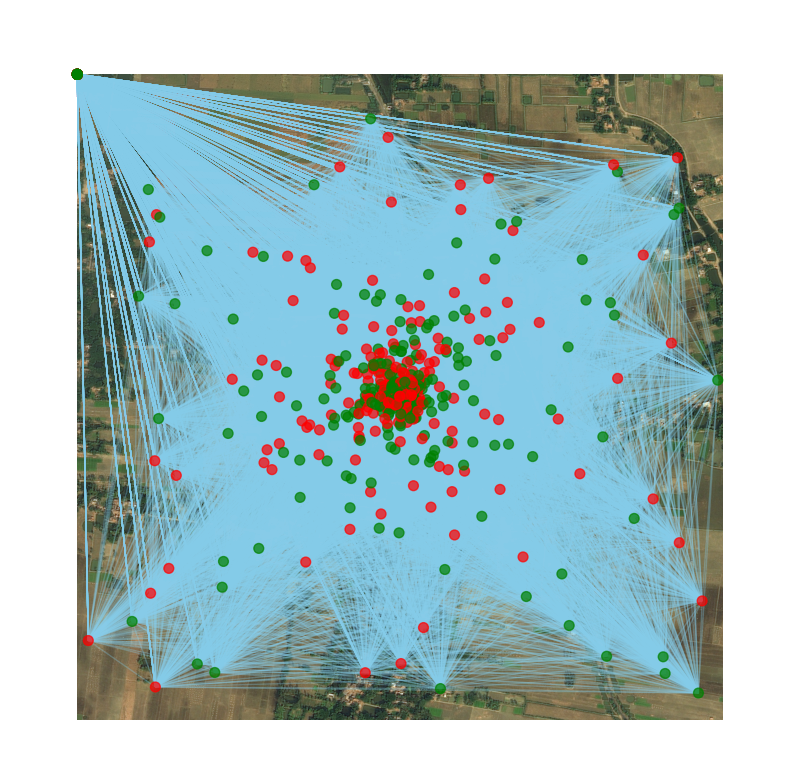

In [18]:
def scale_centroids(centroids, original_size, resized_size):
    """
    Scales centroids from the resized image back to the original image resolution.
    
    Parameters:
        centroids (np.ndarray): Array of centroids on the resized image.
        original_size (tuple): Original image size (height, width).
        resized_size (tuple): Resized image size (height, width).
        
    Returns:
        scaled_centroids (np.ndarray): Centroids scaled back to original resolution.
    """
    scale_y = original_size[0] / resized_size[0]
    scale_x = original_size[1] / resized_size[1]
    
    scaled_centroids = np.copy(centroids)
    scaled_centroids[:, 0] *= scale_y  # Scale y-coordinate (height)
    scaled_centroids[:, 1] *= scale_x  # Scale x-coordinate (width)
    
    return scaled_centroids

def overlay_graph_on_image(image_path, graph, centroids, original_size, resized_size, land_labels, save_path=None):
    """
    Overlays the constructed graph onto the original satellite image.
    
    Parameters:
        image_path (str): Path to the satellite image.
        graph (nx.Graph): Constructed graph.
        centroids (np.ndarray): Array of node centroids (N, 2) on resized image.
        original_size (tuple): Original image size (height, width).
        resized_size (tuple): Resized image size (height, width).
        land_labels (np.ndarray): Array with 0 (agricultural) and 1 (non-agricultural) labels for each node.
        save_path (str, optional): Path to save the overlaid image. Defaults to None.
    """
    # Load the original satellite image
    image = io.imread(image_path)
    
    # Rescale centroids back to original resolution
    scaled_centroids = scale_centroids(centroids, original_size, resized_size)
    
    # Create a plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    
    # Define node colors: red for non-agricultural, green for agricultural
    node_colors = ['green' if label == 0 else 'red' for label in land_labels]
    
    # Overlay the graph
    pos = {i: (scaled_centroid[1], scaled_centroid[0]) for i, scaled_centroid in enumerate(scaled_centroids)}  # (x, y) format
    
    # Draw nodes with specific colors
    nx.draw_networkx_nodes(
        graph, 
        pos, 
        node_size=50, 
        node_color=node_colors, 
        alpha=0.7  # slightly transparent nodes
    )
    
    # Draw edges with a lighter blue color and lower alpha for transparency
    nx.draw_networkx_edges(
        graph, 
        pos, 
        edge_color="skyblue", 
        alpha=0.3,  # lower alpha for lighter edges
        width=1
    )
    
    # Save or show the result
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

# Example usage
original_size = (2448, 2448)  #Original image size (height, width)
resized_size = (512, 512)     #Resized image size (height, width)

image_path = "/kaggle/input/practice1/dummy/images/103730_sat.jpg"
save_path = "/kaggle/working/overlayed1_graph.jpg"

# Example labels for land (0 = agricultural, 1 = non-agricultural)
land_labels = np.random.choice([1, 0], size=len(graph.nodes))  #nodes with random land labels

overlay_graph_on_image(image_path, graph, centroids, original_size, resized_size, land_labels, save_path=save_path)

In [19]:
def graph_to_data(G):
    x = torch.tensor([G.nodes[node]['feature'] for node in G.nodes], dtype=torch.float)
    y = torch.tensor([G.nodes[node]['label'] for node in G.nodes], dtype=torch.long)
    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    return Data(x=x, edge_index=edge_index, y=y)

In [20]:
#Convert the graph to PyTorch Geometric Data
data = graph_to_data(graph)
display(data.size)

/tmp/ipykernel_30/583535594.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  x = torch.tensor([G.nodes[node]['feature'] for node in G.nodes], dtype=torch.float)


<bound method BaseData.size of Data(x=[562, 2048], edge_index=[2, 93769], y=[562])>

In [21]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2)

  1%|▏         | 5/400 [00:00<00:17, 23.04it/s]

Epoch 0, Loss: 1.4450, Accuracy: 0.6281, LR: 0.005000


  4%|▍         | 17/400 [00:00<00:10, 34.97it/s]

Epoch 10, Loss: 0.9935, Accuracy: 0.9377, LR: 0.005000


  6%|▋         | 26/400 [00:00<00:09, 38.61it/s]

Epoch 20, Loss: 0.1910, Accuracy: 0.9715, LR: 0.005000


  9%|▉         | 36/400 [00:01<00:09, 40.24it/s]

Epoch 30, Loss: 0.1238, Accuracy: 0.9662, LR: 0.005000


 12%|█▏        | 46/400 [00:01<00:08, 39.85it/s]

Epoch 40, Loss: 0.1533, Accuracy: 0.9431, LR: 0.005000


 14%|█▍        | 58/400 [00:01<00:08, 39.31it/s]

Epoch 50, Loss: 0.2422, Accuracy: 0.9288, LR: 0.002500


 17%|█▋        | 67/400 [00:01<00:08, 40.20it/s]

Epoch 60, Loss: 0.0913, Accuracy: 0.9698, LR: 0.002500


 19%|█▉        | 77/400 [00:02<00:08, 39.77it/s]

Epoch 70, Loss: 0.0944, Accuracy: 0.9786, LR: 0.002500


 21%|██▏       | 85/400 [00:02<00:08, 38.82it/s]

Epoch 80, Loss: 0.0891, Accuracy: 0.9626, LR: 0.002500


 24%|██▍       | 97/400 [00:02<00:07, 38.88it/s]

Epoch 90, Loss: 0.1074, Accuracy: 0.9591, LR: 0.002500


 26%|██▋       | 106/400 [00:02<00:07, 39.53it/s]

Epoch 100, Loss: 0.1073, Accuracy: 0.9591, LR: 0.001250


 30%|██▉       | 118/400 [00:03<00:07, 38.82it/s]

Epoch 110, Loss: 0.0769, Accuracy: 0.9715, LR: 0.001250


 32%|███▏      | 126/400 [00:03<00:07, 38.73it/s]

Epoch 120, Loss: 0.0832, Accuracy: 0.9715, LR: 0.001250


 34%|███▍      | 135/400 [00:03<00:06, 39.60it/s]

Epoch 130, Loss: 0.0882, Accuracy: 0.9644, LR: 0.001250


 37%|███▋      | 148/400 [00:03<00:06, 39.63it/s]

Epoch 140, Loss: 0.0848, Accuracy: 0.9698, LR: 0.001250


 39%|███▉      | 156/400 [00:04<00:06, 39.13it/s]

Epoch 150, Loss: 0.0776, Accuracy: 0.9733, LR: 0.000625


 41%|████▏     | 165/400 [00:04<00:05, 39.69it/s]

Epoch 160, Loss: 0.0751, Accuracy: 0.9751, LR: 0.000625


 44%|████▍     | 175/400 [00:04<00:05, 40.76it/s]

Epoch 170, Loss: 0.0777, Accuracy: 0.9715, LR: 0.000625


 46%|████▋     | 185/400 [00:04<00:05, 39.93it/s]

Epoch 180, Loss: 0.0786, Accuracy: 0.9733, LR: 0.000625


 50%|████▉     | 198/400 [00:05<00:05, 40.01it/s]

Epoch 190, Loss: 0.0798, Accuracy: 0.9751, LR: 0.000625


 52%|█████▏    | 208/400 [00:05<00:04, 40.85it/s]

Epoch 200, Loss: 0.0930, Accuracy: 0.9715, LR: 0.000313


 55%|█████▍    | 218/400 [00:05<00:04, 39.90it/s]

Epoch 210, Loss: 0.0752, Accuracy: 0.9733, LR: 0.000313


 56%|█████▋    | 226/400 [00:05<00:04, 39.09it/s]

Epoch 220, Loss: 0.0794, Accuracy: 0.9733, LR: 0.000313


 59%|█████▉    | 236/400 [00:06<00:04, 40.13it/s]

Epoch 230, Loss: 0.0827, Accuracy: 0.9769, LR: 0.000313


 62%|██████▏   | 246/400 [00:06<00:03, 40.23it/s]

Epoch 240, Loss: 0.0843, Accuracy: 0.9680, LR: 0.000313


 64%|██████▍   | 255/400 [00:06<00:03, 39.39it/s]

Epoch 250, Loss: 0.0815, Accuracy: 0.9698, LR: 0.000156


 67%|██████▋   | 268/400 [00:06<00:03, 39.96it/s]

Epoch 260, Loss: 0.0823, Accuracy: 0.9715, LR: 0.000156


 70%|██████▉   | 278/400 [00:07<00:02, 40.77it/s]

Epoch 270, Loss: 0.0809, Accuracy: 0.9698, LR: 0.000156


 72%|███████▏  | 287/400 [00:07<00:02, 39.62it/s]

Epoch 280, Loss: 0.0771, Accuracy: 0.9698, LR: 0.000156


 74%|███████▍  | 295/400 [00:07<00:02, 39.09it/s]

Epoch 290, Loss: 0.0782, Accuracy: 0.9751, LR: 0.000156


 77%|███████▋  | 309/400 [00:07<00:02, 39.85it/s]

Epoch 300, Loss: 0.0759, Accuracy: 0.9733, LR: 0.000078


 80%|███████▉  | 319/400 [00:08<00:02, 39.85it/s]

Epoch 310, Loss: 0.0817, Accuracy: 0.9733, LR: 0.000078


 82%|████████▏ | 327/400 [00:08<00:01, 39.26it/s]

Epoch 320, Loss: 0.0785, Accuracy: 0.9715, LR: 0.000078


 84%|████████▍ | 335/400 [00:08<00:01, 38.96it/s]

Epoch 330, Loss: 0.0746, Accuracy: 0.9751, LR: 0.000078


 87%|████████▋ | 348/400 [00:08<00:01, 38.27it/s]

Epoch 340, Loss: 0.0834, Accuracy: 0.9662, LR: 0.000078


 89%|████████▉ | 356/400 [00:09<00:01, 38.30it/s]

Epoch 350, Loss: 0.0859, Accuracy: 0.9662, LR: 0.000039


 92%|█████████▏| 369/400 [00:09<00:00, 39.37it/s]

Epoch 360, Loss: 0.0809, Accuracy: 0.9733, LR: 0.000039


 94%|█████████▍| 378/400 [00:09<00:00, 39.61it/s]

Epoch 370, Loss: 0.0811, Accuracy: 0.9680, LR: 0.000039


 96%|█████████▋| 386/400 [00:09<00:00, 38.76it/s]

Epoch 380, Loss: 0.0786, Accuracy: 0.9698, LR: 0.000039


100%|█████████▉| 398/400 [00:10<00:00, 38.95it/s]

Epoch 390, Loss: 0.0795, Accuracy: 0.9751, LR: 0.000039


100%|██████████| 400/400 [00:10<00:00, 38.97it/s]


Model saved to gcn_model_optimized.pth


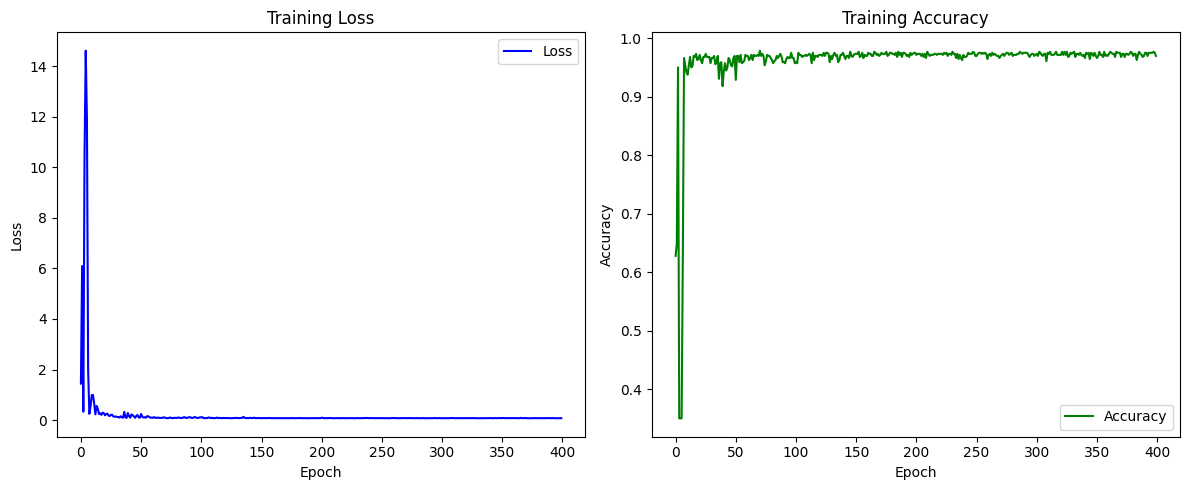

In [22]:
def train_gcn(
    model, data, epochs=400, lr=0.01, weight_decay=5e-4, save_path="gcn_model_optimized.pth"
):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()  #Would Consider nn.BCEWithLogitsLoss for binary tasks
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    #Lists to track loss and accuracy over epochs
    losses = []
    accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()

        #Forward pass
        out = model(data)

        #Compute loss
        loss = criterion(out, data.y)
        losses.append(loss.item())

        #Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()
        scheduler.step()  #Adjust learning rate

        #Calculate accuracy
        model.eval()
        with torch.no_grad():
            predictions = out.argmax(dim=1)  # Predicted class
            correct = (predictions == data.y).sum().item()
            accuracy = correct / data.y.size(0)
            accuracies.append(accuracy)

        #Print loss and accuracy every 10 epochs
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, "
                f"LR: {scheduler.get_last_lr()[0]:.6f}"
            )

    #Save the trained model
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    #Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    #Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), losses, label="Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    #Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracies, label="Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

train_gcn(gcn_model, data, epochs=400, lr=0.005, weight_decay=1e-4, save_path="gcn_model_optimized.pth")

Classification Report:

                  precision    recall  f1-score   support

Non-Agricultural       0.97      0.96      0.96       197
    Agricultural       0.98      0.98      0.98       365

        accuracy                           0.98       562
       macro avg       0.97      0.97      0.97       562
    weighted avg       0.98      0.98      0.98       562



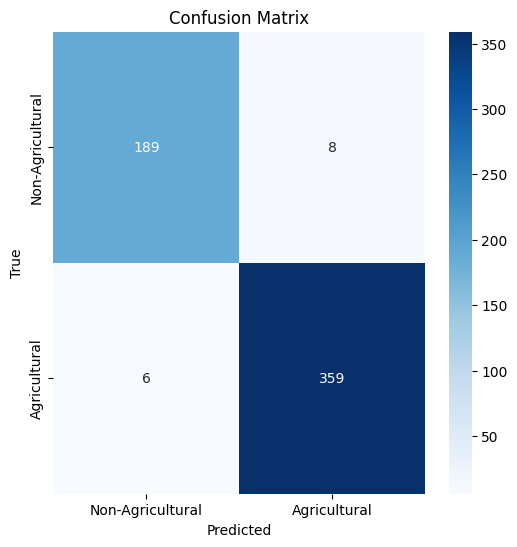

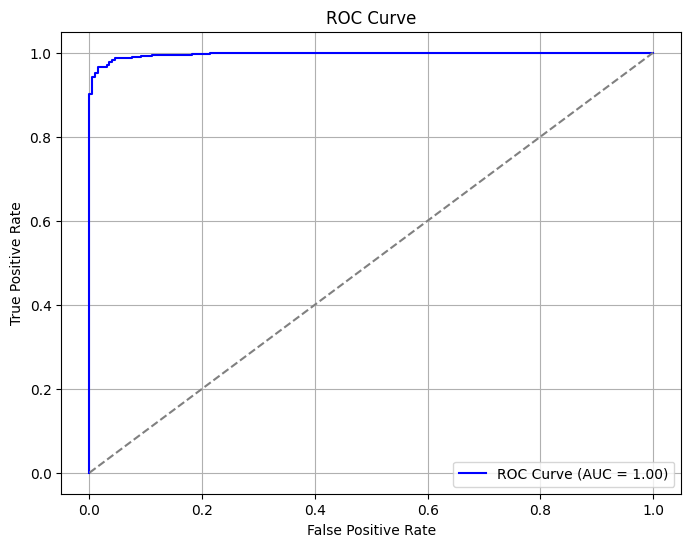

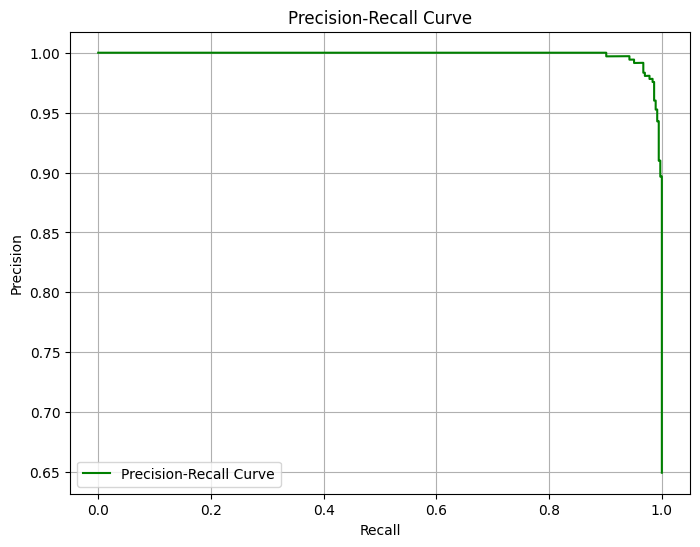

In [26]:
def evaluate_gcn_model(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1).cpu().numpy()  # Predicted classes
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()  # Probability for positive class
        true_labels = data.y.cpu().numpy()  # True labels
    
    # Classification Report
    print("Classification Report:\n")
    print(classification_report(true_labels, preds, target_names=["Non-Agricultural", "Agricultural"]))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Agricultural", "Agricultural"],
                yticklabels=["Non-Agricultural", "Agricultural"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color="green", label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()
    
evaluate_gcn_model(gcn_model, data)

## Metrics out from the classification report

`PR-AUC (Precision-Recall Area Under Curve)`
- Particularly useful for imbalanced datasets; focuses on the performance for the positive class.

`Log Loss (Cross-Entropy Loss)`
- Quantifies the difference between predicted probabilities and true labels.

`Matthews Correlation Coefficient (MCC)`
- Evaluates the correlation between predicted and true labels, suitable for imbalanced datasets.

`Cohen’s Kappa`
- Measures inter-annotator agreement adjusted for chance. Useful for classification tasks with imbalances.

`Confusion Matrix`
- Provides insight into true positive, true negative, false positive, and false negative counts.

`Balanced Accuracy`
- Takes the average of recall obtained on each class. Useful for imbalanced datasets.

In [27]:
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    log_loss,
    matthews_corrcoef,
    cohen_kappa_score,
    confusion_matrix,
    balanced_accuracy_score,
)

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        # Model predictions
        out = model(data)
        probabilities = torch.softmax(out, dim=1)[:, 1].cpu().numpy()  # Probability for positive class
        predicted_labels = out.argmax(dim=1).cpu().numpy()  # Predicted class
        true_labels = data.y.cpu().numpy()  # Ground truth labels

    # Compute evaluation metrics
    metrics = {
        "PR-AUC": auc(*precision_recall_curve(true_labels, probabilities)[1::-1]),
        "Log Loss": log_loss(true_labels, probabilities),
        "MCC": matthews_corrcoef(true_labels, predicted_labels),
        "Cohen’s Kappa": cohen_kappa_score(true_labels, predicted_labels),
        "Balanced Accuracy": balanced_accuracy_score(true_labels, predicted_labels),
        "Confusion Matrix": confusion_matrix(true_labels, predicted_labels).tolist(),  # Convert to list for readability
    }

    return metrics

metrics = evaluate_model(gcn_model, data)
for metric, value in metrics.items():
    if metric == "Confusion Matrix":
        print(f"{metric}:\n{value}")
    else:
        print(f"{metric}: {value:.4f}")

PR-AUC: 0.9984
Log Loss: 0.0756
MCC: 0.9452
Cohen’s Kappa: 0.9452
Balanced Accuracy: 0.9715
Confusion Matrix:
[[189, 8], [6, 359]]


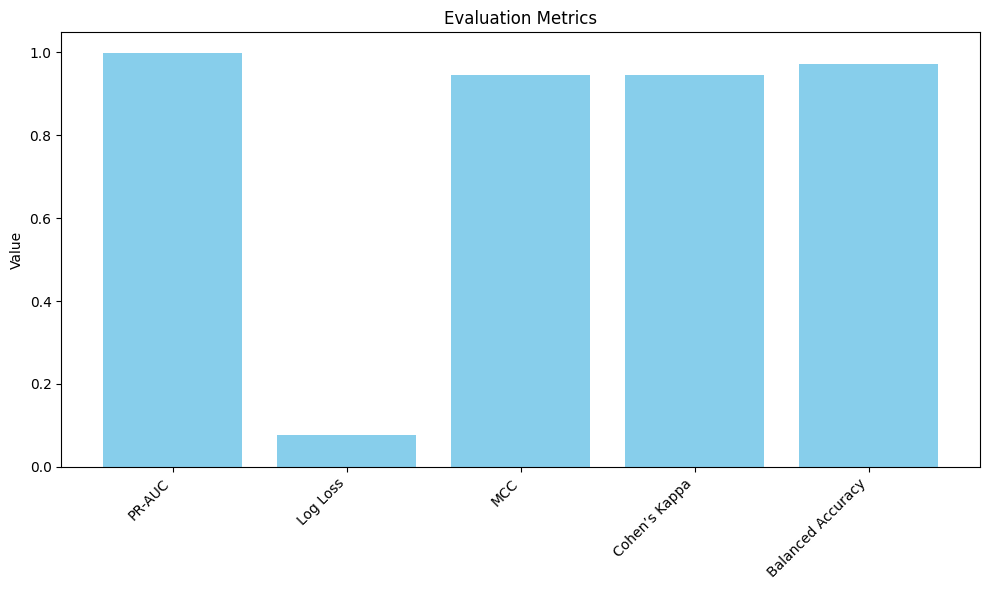

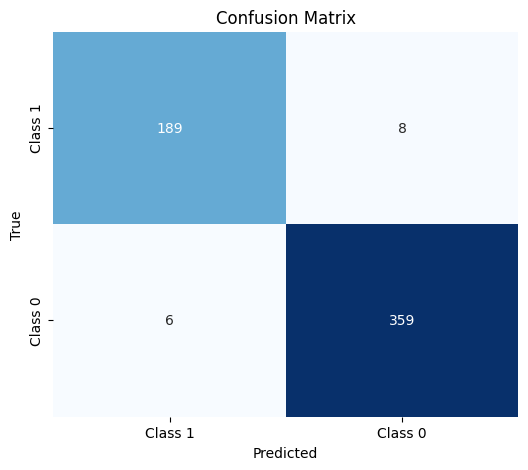

In [29]:
import seaborn as sns

def plot_metrics(metrics):
    #Separate metrics for scalar values and confusion matrix
    scalar_metrics = {k: v for k, v in metrics.items() if k != "Confusion Matrix"}
    confusion_matrix = metrics["Confusion Matrix"]

    #Bar plot for scalar metrics
    plt.figure(figsize=(10, 6))
    plt.bar(scalar_metrics.keys(), scalar_metrics.values(), color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Value")
    plt.title("Evaluation Metrics")
    plt.tight_layout()
    plt.show()

    #Heatmap for confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Class 1", "Class 0"], yticklabels=["Class 1", "Class 0"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

metrics = evaluate_model(gcn_model, data)
plot_metrics(metrics)

## Suggestions:

- `Validation of Graph Representation:` Ensure the graph's construction accurately reflects spatial or feature-based relationships (e.g., adjacency, shared borders, or feature similarity). This step is critical for the robustness of GNN models.
- `Iterative Improvements:` Experiment with different GNN architectures (e.g., GAT, GraphSAGE) if GCN performance does not meet expectations.
- Rigorous testing across diverse scenarios and datasets to evaluate robustness.

In [ ]:
gcn_model.eval()
with torch.no_grad():
    gcn_predictions = gcn_model(data)
    # Apply softmax for multi-class or sigmoid for binary classification
    gcn_preds = torch.sigmoid(F.softmax(gcn_predictions, dim=1))
    #If binary classification, you can also use torch.sigmoid(gcn_predictions).round()

In [ ]:
def map_gcn_predictions_to_image(predictions, centroids, image_size=(512, 512)):
    """
    Maps the GCN predictions to an image, based on centroid locations.
    
    Parameters:
        predictions (torch.Tensor): The output of the GCN model (size: N x C), where N is the number of nodes and C is the number of classes.
        centroids (np.ndarray): Centroid positions for each node, shape (N, 2), where N is the number of nodes.
        image_size (tuple): The size of the output image (height, width).
        
    Returns:
        image_predictions (np.ndarray): A 2D array representing the predicted binary mask.
    """
    # Initialize an empty image with zeros
    image_predictions = np.zeros(image_size, dtype=np.uint8)

    for i, (centroid, pred) in enumerate(zip(centroids, predictions)):
        # Extract the centroid (x, y) position
        x, y = int(centroid[0]), int(centroid[1])

        # If the model produces multi-class predictions, choose the class with the highest probability
        predicted_class = pred.argmax().item()  # Get the class with the maximum probability

        # Ensure the coordinates are within bounds
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            image_predictions[x, y] = predicted_class  # Assign the predicted class label to the pixel
    
    return image_predictions

In [ ]:
def visualize_predictions(image, mask, gcn_pred, ground_truth_pred):
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    # Threshold GCN predictions to create a binary mask
    gcn_pred_bin = (gcn_pred.squeeze() > 0.5).astype(np.uint8)  # Apply thresholding

    # Image
    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth Mask
    axes[1].imshow(mask.squeeze(), cmap='jet', alpha=0.5)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # GCN Prediction Mask
    axes[2].imshow(gcn_pred_bin, cmap='jet', alpha=0.5)
    axes[2].set_title("GCN Prediction Mask")
    axes[2].axis("off")

    # Ground Truth Prediction
    axes[3].imshow(ground_truth_pred.squeeze(), cmap='jet', alpha=0.5)
    axes[3].set_title("Ground Truth Prediction")
    axes[3].axis("off")

    plt.show()

In [ ]:
#Map GCN predictions to image
gcn_pred = map_gcn_predictions_to_image(gcn_preds, centroids, image_size=(512, 512))

In [ ]:
# Ground truth predictions from the mask (binary)
ground_truth_pred = (mask > 0.5).int() 

In [ ]:
# Visualize the results
visualize_predictions(image.numpy().transpose(1, 2, 0), mask.numpy(), gcn_pred, ground_truth_pred)